In [97]:
using PauliPropagation
using Random
using Optim
using Plots
Random.seed!(43)
using ReverseDiff: GradientTape, gradient!, compile, gradient
using LinearAlgebra
using StatsBase 
using GLM
using DataFrames
using CSV
using Format
using Logging

# CDR for quantum dynamics
- TFIM Hamiltonian (constants not site-dependent) evolving with TDSE
- discretize the evolution steps and use first-order Trotter decomposition 

### Idea:
- DONE: Run "exact" evolution for small trotterized circuit
- DONE: Create near-Clifford circuits:replace some gates in Trotterized gate by close Cliffords - no VQA here so this is much simpler, find closest Clifford to the RZZ and to the RX (only have 2 angles in total), replace a portion randomly (no MCMC), keep the parameter of N = non-Cliffords const. st. system remains cl. scalable.
- create MWE of CDR within quantum dynamics
- which gates ones we replace has influence on the accuracy of the expectation value (principle of causal light cone as seen in vnCDR paper Piotr, is this automatically respected within Heisenberg picture? (backprop observable)), so we can aim to replace only gates that contribute to an expectation value (works only for single-qubit / local observables)
- another idea is to try the perturbation approach (all non-Cliffords) 



In [98]:
struct trotter_ansatz
    target_circuit::Vector{Gate}
    target_circuit_layer::Vector{Gate}
    topology::Vector{Tuple{Int64, Int64}}
    nqubits::Integer
    steps::Integer #layers
    time::Integer
    J::Float64
    h::Float64
    sigma_J::Float64
    sigma_h::Float64
    sigma_J_indices::Vector{Int64}
    sigma_h_indices::Vector{Int64}
    sigma_J_indices_layer::Vector{Int64}
    sigma_h_indices_layer::Vector{Int64}
end

In [99]:
function trotter_setup(nqubits::Integer, steps::Integer, time::Float64, J::Float64, h::Float64; topology = nothing)
    if isnothing(topology)
        topology = bricklayertopology(nqubits)
    end
    target_circuit = tfitrottercircuit(nqubits,steps,topology=topology) #start with RZZ layer
    target_circuit_layer = tfitrottercircuit(nqubits,1,topology=topology) #start with RZZ layer
    sigma_J = -2*T*J/steps
    sigma_h = 2*T*h/steps 

    sigma_J_indices = getparameterindices(target_circuit, PauliRotation, [:Z,:Z]) 
    sigma_h_indices = getparameterindices(target_circuit, PauliRotation, [:X])
    
    sigma_J_indices_layer = getparameterindices(target_circuit_layer, PauliRotation, [:Z,:Z])
    sigma_h_indices_layer = getparameterindices(target_circuit_layer, PauliRotation, [:X])
    
    return trotter_ansatz(target_circuit,target_circuit_layer, topology, nqubits, steps, time, J, h,sigma_J, sigma_h,sigma_J_indices, sigma_h_indices, sigma_J_indices_layer, sigma_h_indices_layer)
end

trotter_setup (generic function with 1 method)

In [100]:
function constrain_params(ansatz; layer = false)
    if !layer
        nparams = countparameters(ansatz.target_circuit)
        thetas = zeros(nparams)
        thetas[ansatz.sigma_h_indices] .= ansatz.sigma_h
        thetas[ansatz.sigma_J_indices] .= ansatz.sigma_J
    else
        nparams = countparameters(ansatz.target_circuit_layer)
        thetas = zeros(nparams)
        thetas[ansatz.sigma_h_indices_layer] .= ansatz.sigma_h
        thetas[ansatz.sigma_J_indices_layer] .= ansatz.sigma_J
    end
    
    return thetas
end

constrain_params (generic function with 1 method)

In [101]:
function obs_magnetization(ansatz)
    magnetization = PauliSum(ansatz.nqubits)
    for i in 1:nq
        add!(magnetization,:Z,i)
    end
    magnetization = magnetization/nq
    return magnetization
end

obs_magnetization (generic function with 1 method)

In [ ]:
function trotter_time_evolution(ansatz; special_theta=nothing, noise_kind="noiseless", record=false, min_abs_coeff=0, depol_strength=0.01, dephase_strength=0.01)

    layer = record
    if special_theta==nothing
        thetas = constrain_params(ansatz,layer=layer)
    else
        thetas = special_theta
    end
    obs = obs_magnetization(ansatz)


    if noise_kind=="naive"
        circuit = final_noise_layer_circuit(ansatz; depol_strength, dephase_strength)
    elseif noise_kind=="gate"
        circuit = gate_noise_circuit(ansatz; depol_strength, dephase_strength)
    elseif noise_kind=="noiseless"
        if record
            circuit = copy(ansatz.target_circuit_layer)
        else
            circuit = copy(ansatz.target_circuit)
        end
    else
        error("Noise kind $noise_kind unknown.")
    end

    if record
        expvals_trotter = Float64[]   
        push!(expvals_trotter, overlapwithzero(obs))
        for i in 1:ansatz.steps
            psum = propagate!(circuit, obs, thetas)
            push!(expvals_trotter, overlapwithzero(psum))
        end
        return expvals_trotter  
    else 
        psum = propagate!(circuit,obs,thetas)
        return overlapwithzero(psum)
    end
end

trotter_time_evolution (generic function with 1 method)

In [103]:
function training_set_generation_brut(ansatz::trotter_ansatz, angle_definition::Float64; num_samples::Int = 10, non_cliffs::Int = 30)
    nparams = countparameters(ansatz.target_circuit)
    cliffs = nparams - non_cliffs
    ratio = length(ansatz.sigma_J_indices)/(length(ansatz.sigma_h_indices)+length(ansatz.sigma_J_indices))
    num_h = Int(round((1-ratio)*cliffs))
    num_J = Int(round(ratio*cliffs))
    training_thetas_list = Vector{Vector{Float64}}()
    thetas = constrain_params(ansatz)
    for _ in 1:num_samples
        training_thetas = deepcopy(thetas)
        shuffled_sigma_h_indices =  Random.shuffle!(ansatz.sigma_h_indices)
        shuffled_sigma_J_indices = Random.shuffle!(ansatz.sigma_J_indices)
        selected_indices_h = shuffled_sigma_h_indices[1:num_h]
        selected_indices_J = shuffled_sigma_J_indices[1:num_J];   
        k_h =round(ansatz.sigma_h/(angle_definition))
        k_J =round(ansatz.sigma_J/(angle_definition))

        for i in selected_indices_h
            training_thetas[i] = k_h*angle_definition
        end
        for i in selected_indices_J
            training_thetas[i] = k_J*angle_definition
        end
        push!(training_thetas_list, training_thetas)
    end
    return training_thetas_list
end

training_set_generation_brut (generic function with 1 method)

In [104]:
function training_trotter_time_evolution(ansatz, training_thetas, noise_kind, min_abs_coeff)
    exact_expvals = Vector{Float64}()
    for thetas in training_thetas
        push!(exact_expvals, trotter_time_evolution(ansatz; special_theta=thetas, noise_kind=noise_kind, min_abs_coeff=min_abs_coeff))
    end
    return exact_expvals
end

training_trotter_time_evolution (generic function with 1 method)

In [105]:
function final_noise_layer_circuit(ansatz; depol_strength = 0.05, dephase_strength = 0.05)
    #to be replaced with a decent noise model
    depol_noise_layer = [DepolarizingNoise(qind, depol_strength ) for qind in 1:ansatz.nqubits];
    dephase_noise_layer = [DephasingNoise(qind, dephase_strength) for qind in 1:ansatz.nqubits];
    noisy_circuit = deepcopy(ansatz.target_circuit)
    append!(noisy_circuit,depol_noise_layer)
    append!(noisy_circuit,dephase_noise_layer)

    return noisy_circuit
end

function gate_noise_circuit(ansatz;depol_strength =0.01, dephase_strength = 0.01, topology=nothing, start_with_ZZ=true)
    circuit::Vector{Gate} = []

    topology = ansatz.topology
    if isnothing(topology)
        topology = bricklayertopology(ansatz.nqubits)
    end

    # the function after this expects a circuit with at least one layer and will always append something
    if ansatz.steps == 0
        return circuit
    end

    depol_noise_layer = [DepolarizingNoise(qind, depol_strength ) for qind in 1:ansatz.nqubits];
    phase_damp_layer = [DephasingNoise(qind, dephase_strength) for qind in 1:ansatz.nqubits];

    if start_with_ZZ
        rzzlayer!(circuit, ansatz.topology)
        append!(circuit,depol_noise_layer)
        append!(circuit,phase_damp_layer)
    end

    for _ in 1:ansatz.steps-1
        rxlayer!(circuit, ansatz.nqubits)
        append!(circuit,depol_noise_layer)
        append!(circuit,phase_damp_layer)
        rzzlayer!(circuit, ansatz.topology)
        append!(circuit,depol_noise_layer)
        append!(circuit,phase_damp_layer)
    end

    rxlayer!(circuit, ansatz.nqubits)
    append!(circuit,depol_noise_layer)
    append!(circuit,phase_damp_layer)

    if !start_with_ZZ
        rzzlayer!(circuit, ansatz.topology)
        append!(circuit,depol_noise_layer)
        append!(circuit,phase_damp_layer)
    end

    return circuit
end

gate_noise_circuit (generic function with 1 method)

In [106]:
# function noisy_time_evolution_brut(ansatz, exact_training_thetas, min_abs_coeff=0, noise_kind="naive"; depol_strength = 0.05, dephase_strength = 0.05)
#     noisy_expvals = Vector{Float64}()

#     if noise_kind=="naive"
#         noisy_circuit = final_noise_layer_circuit(ansatz; depol_strength, dephase_strength)
#     elseif noise_kind=="gate"
#         noisy_circuit = gate_noise_circuit(ansatz; depol_strength, dephase_strength)
#     else
#         error("Noise kind $noise_kind unknown.")
#     end

#     for i in 1:length(exact_training_thetas)
#         obs = obs_magnetization(ansatz)
#         thetas = exact_training_thetas[i]
#         psum = propagate(noisy_circuit,obs,thetas; min_abs_coeff=min_abs_coeff)
#         push!(noisy_expvals, overlapwithzero(psum))
#     end

#     return noisy_expvals
# end

### Exact evolution of a small trotterized circuit (see CPDR p.7)

In [107]:
# nq = 32
# steps = 10
# T = 1.0
# J = 5.0 #J > 0 in ferromagnetic phase, J < 0 in antiferromagnetic phase
# h = 1.0 #abs(h) < abs(J) in ordered phase
# trotter = trotter_setup(nq, steps, T, J, h);

# min_abs_coeff = 1e-6;
# min_abs_coeff_noisy = min_abs_coeff;

In [108]:
# exact_expval_target = exact_trotter_time_evolution(trotter) #should be close to one as we stay in FM phase

In [109]:
# noisy_expval_target = noisy_time_evolution_brut(trotter, [constrain_params(trotter)], min_abs_coeff_noisy)

### Training set generation

In [110]:
# num_samples = 10
# angle_definition = pi/8
# list = training_set_generation_brut(trotter, angle_definition; num_samples = 10, non_cliffs = 30);

### Exact time evolution for the training set

In [111]:

# exact_expvals = training_exact_time_evolution_brut(trotter,list,min_abs_coeff);

### Noisy expectation values
- 1 layer of depolarizing and dephasing noise
- for more realistic noise model, add after each gate

In [112]:
# noisy_expvals = noisy_time_evolution_brut(trotter,list,min_abs_coeff_noisy);

### CDR

In [113]:
function cdr(noisy_exp_values::Vector{Float64}, exact_exp_values::Vector{Float64}, noisy_target_exp_value::Float64, exact_target_exp_value::Float64)
    training_data = DataFrame(x=noisy_exp_values,y=exact_exp_values)
    ols = lm(@formula(y ~ x), training_data)
    function cdr_em(x)
        return  coef(ols)[1] + coef(ols)[2] * x
    end
    rel_error_after = abs(exact_target_exp_value - cdr_em(noisy_target_exp_value)) / abs(exact_target_exp_value)
    rel_error_before = abs(exact_target_exp_value - noisy_target_exp_value) / abs(exact_target_exp_value)
    # if verbose
    #     println(training_data)
    #     println("Noisy target expectation value: ", noisy_target_exp_value)
    #     println("Relative error before CDR: ", rel_error_before)
    #     println("CDR-EM target expectation value: ", cdr_em(noisy_target_exp_value))
    #     println("Relative error after CDR: ", rel_error_after)
    # end
    @debug training_data
    @debug "Noisy target expectation value: " noisy_target_exp_value
    @debug "Relative error before CDR: " rel_error_before
    @debug "CDR-EM target expectation value: " cdr_em(noisy_target_exp_value)
    @debug "Relative error after CDR: " rel_error_after
    return cdr_em(noisy_target_exp_value), rel_error_after, rel_error_before
end 

cdr (generic function with 1 method)

In [114]:
# corr_energy, rel_error_after, rel_error_before = cdr(noisy_expvals, exact_expvals, noisy_expval_target[1], exact_expval_target; verbose=true)  

In [115]:

function full_run(ansatz, angle_definition, noise_kind, min_abs_coeff, min_abs_coeff_noisy; num_samples=10)
    @info "ready to ruuuuuummmble"

    time1 = time()
    exact_expval_target = trotter_time_evolution(ansatz; noise_kind="noiseless") #should be close to one as we stay in FM phase
    timetmp1 = time()
    @info "exact_expval_target done in $(round(timetmp1-time1; digits = 2)) s"

    noisy_expval_target = trotter_time_evolution(ansatz; noise_kind=noise_kind)
    timetmp2 = time()
    @info "noisy_expval_target done in $(round(timetmp2-timetmp1; digits = 2)) s"
    timetmp1 = timetmp2
    
    num_samples = 10
    angle_definition = pi/8
    training_set = training_set_generation_brut(ansatz, angle_definition; num_samples=num_samples, non_cliffs = 30); 
    timetmp2 = time()
    @info "training_set_generation_brut done in $(round(timetmp2-timetmp1; digits = 2)) s"
    timetmp1 = timetmp2
    
    
    exact_expvals = training_trotter_time_evolution(ansatz, training_set, "noiseless", min_abs_coeff);
    timetmp2 = time()
    @info "training_exact_time_evolution_brut done in  $(round(timetmp2-timetmp1; digits = 2)) s"
    timetmp1 = timetmp2
    
    noisy_expvals = training_trotter_time_evolution(ansatz, training_set, noise_kind, min_abs_coeff_noisy);
    timetmp2 = time()
    @info "noisy_time_evolution_brut done in  $(round(timetmp2-timetmp1; digits = 2)) s"
    timetmp1 = timetmp2
    
    corr_energy, rel_error_after, rel_error_before = cdr(noisy_expvals, exact_expvals, noisy_expval_target[1], exact_expval_target)  
    timetmp2 = time()
    @info "cdr done in  $(round(timetmp2-timetmp1; digits = 2)) s"

    printfmt("nq={} noise={} total run done in {:.2f} s\n", nq, noise_kind, timetmp2-time1)

    # open file in append mode 
    if noise_kind=="naive"
        log = open("trotter_brut_naive.log", "a")  
    elseif noise_kind=="gate"
        log = open("trotter_brut_gate.log", "a")
    else
        error("Noise kind $noise_kind unknown.")
    end
    str = format("{:>5n} {:>5n} {:>6.2e} {:>10.2e} {:>10.2e} {:>10.2e} {:>10.2e} {:>10.2e} {:>10.2e} {:>10.2e} {:>10.2e} {:>10.2e} {:>10.2e}\n", nq, steps, T, J, h, angle_definition, min_abs_coeff, min_abs_coeff_noisy, exact_expval_target, noisy_expval_target[1], rel_error_before, rel_error_after, timetmp2-time1);
    # writing to a file using write() method  
    write(log, str)  
        
    # We need to close the file in order to write the content from the disk to file  
    close(log)
    return exact_expval_target, noisy_expval_target[1], corr_energy, rel_error_before, rel_error_after
end

full_run (generic function with 2 methods)

In [116]:
# infologger = ConsoleLogger(stderr, Logging.Info)
# global_logger(infologger)

struct UnbufferedLogger <: Logging.AbstractLogger
    stream::IO
    level::Logging.LogLevel
end

Logging.min_enabled_level(logger::UnbufferedLogger) = logger.level
Logging.shouldlog(logger::UnbufferedLogger, level, _module, group, id) = level ≥ logger.level
Logging.catch_exceptions(::UnbufferedLogger) = true

function Logging.handle_message(logger::UnbufferedLogger, level, message, _module, group, id, file, line)
    print(logger.stream, "[$level] ", message, "\n")  # Include log level
    flush(logger.stream)  # Ensure immediate output
end

# Set the unbuffered logger globally
global_logger(UnbufferedLogger(stdout, Logging.Info))


nq = 8
steps = 10
angle_definition = pi/8
T = 1.
J = 5.0 #J > 0 in ferromagnetic phase, J < 0 in antiferromagnetic phase
h = 1.0 #abs(h) < abs(J) in ordered phase
# J = 1.0 #J > 0 in ferromagnetic phase, J < 0 in antiferromagnetic phase
# h = -2.0 #abs(h) < abs(J) in ordered phase
trotter = trotter_setup(nq, steps, T, J, h);

noise_kind = "gate"
min_abs_coeff = 1e-10;
min_abs_coeff_noisy = min_abs_coeff;

# with_logger(infologger) do
#     full_run(nq, steps, angle_definition, T, J, h, trotter, noise_kind, min_abs_coeff, min_abs_coeff_noisy)
# end
full_run(trotter, angle_definition, noise_kind, min_abs_coeff, min_abs_coeff_noisy)


[Info] ready to ruuuuuummmble
[Info] exact_expval_target done in 0.08 s
[Info] noisy_expval_target done in 0.25 s
[Info] training_set_generation_brut done in 0.0 s
[Info] training_exact_time_evolution_brut done in  1.34 s
[Info] noisy_time_evolution_brut done in  4.73 s
[Info] cdr done in  0.01 s
nq=8 noise=gate total run done in 6.41 s


(0.9578665548250215, 0.7295983642404753, 1.0928597514490477, 0.2383089684410634, 0.1409311098127715)

In [89]:
nqubits = 8
steps = 10
angle_definition = pi/4
T = 1.0
J = 5.0 #J > 0 in ferromagnetic phase, J < 0 in antiferromagnetic phase
h = 1.0 #abs(h) < abs(J) in ordered phase
trotter = trotter_setup(nq, steps, T, J, h);
nsamples = 10:10:100

noise_kind = "gate"
min_abs_coeff = 1e-6;
min_abs_coeff_noisy = min_abs_coeff;


rel_err_ratio_gate = []

for nsample=nsamples
    
    exact_expvals, noisy_expvals, corr_energy, rel_error_before, rel_error_after = full_run(trotter, angle_definition, "gate", min_abs_coeff, min_abs_coeff_noisy; num_samples=nsample)
    push!(rel_err_ratio_gate, rel_error_before/rel_error_after)

end



[Info] ready to ruuuuuummmble
[Info] exact_expval_target done in 0.01 s
[Info] noisy_expval_target done in 0.02 s
[Info] training_set_generation_brut done in 0.0 s
[Info] training_exact_time_evolution_brut done in  0.08 s
[Info] noisy_time_evolution_brut done in  0.18 s
[Info] cdr done in  0.0 s
nq=6 noise=gate total run done in 0.29 s
[Info] ready to ruuuuuummmble
[Info] exact_expval_target done in 0.01 s
[Info] noisy_expval_target done in 0.02 s
[Info] training_set_generation_brut done in 0.0 s
[Info] training_exact_time_evolution_brut done in  0.08 s
[Info] noisy_time_evolution_brut done in  0.19 s
[Info] cdr done in  0.0 s
nq=6 noise=gate total run done in 0.29 s
[Info] ready to ruuuuuummmble
[Info] exact_expval_target done in 0.01 s
[Info] noisy_expval_target done in 0.02 s
[Info] training_set_generation_brut done in 0.0 s
[Info] training_exact_time_evolution_brut done in  0.08 s
[Info] noisy_time_evolution_brut done in  0.18 s
[Info] cdr done in  0.0 s
nq=6 noise=gate total run d

In [90]:
df = DataFrame(nqubits = nqubits, rel_err_ratio_gate = rel_err_ratio_gate)
fn = format("data/J={:.2f}_h={:.2f}_T={:.2f}_angdef={:.2f}_steps={:n}_nqubits={:n}_nsamples_{:n}_to_{:n}_minabs={:.2e}_minabsnoisy={:.2e}.csv", J, h, T, angle_definition, steps, nqubits, nsamples[1], nsamples[end], min_abs_coeff, min_abs_coeff_noisy)
CSV.write(fn, df)

"data/J=5.00_h=1.00_T=1.00_angdef=0.79_steps=10_nqubits=8_nsamples_10_to_100_minabs=1.00e-06_minabsnoisy=1.00e-06.csv"

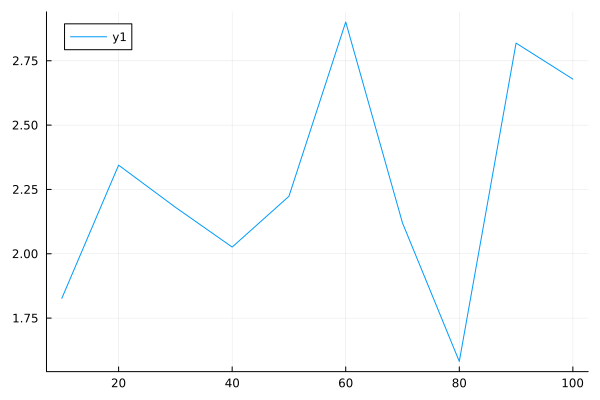

In [91]:
plot(nsamples, rel_err_ratio_gate)


In [ ]:

nqubits = vec([2 4 6 8 12 16 32 64])
steps = 10
angle_definition = pi/8
T = 1.0
J = 5.0 #J > 0 in ferromagnetic phase, J < 0 in antiferromagnetic phase
h = 1.0 #abs(h) < abs(J) in ordered phase
trotter = trotter_setup(nq, steps, T, J, h);

rel_err_ratio_gate = []
rel_err_ratio_naive = []

for nq=nqubits
    exact_expvals, noisy_expvals, corr_energy, rel_error_before, rel_error_after = full_run(nq, steps, angle_definition, T, J, h, trotter, "naive", min_abs_coeff, min_abs_coeff_noisy)
    push!(rel_err_ratio_naive, rel_error_before/rel_error_after)

    exact_expvals, noisy_expvals, corr_energy, rel_error_before, rel_error_after = full_run(nq, steps, angle_definition, T, J, h, trotter, "gate", min_abs_coeff, min_abs_coeff_noisy)
    push!(rel_err_ratio_gate, rel_error_before/rel_error_after)
end



In [24]:
df = DataFrame(nqubits = nqubits, rel_err_ratio_gate = rel_err_ratio_gate, rel_err_ratio_naive = rel_err_ratio_naive)
fn = format("data/J={:.2f}_h={:.2f}_T={:.2f}_angdef={:.2f}_steps={:n}_nqubits={:n}to{:n}_minabs={:.2e}_minabsnoisy={:.2e}.csv", J, h, T, angle_definition, steps, nqubits[1], nqubits[end], min_abs_coeff, min_abs_coeff_noisy)
CSV.write(fn, df)

DimensionMismatch: DimensionMismatch: column :nqubits has length 8 and column :rel_err_ratio_gate has length 0

In [25]:
plot(nqubits, rel_err_ratio_gate)
plot!(nqubits, rel_err_ratio_naive)